# CS498PS - Lab 2: Filter Design and Usage

For this lab you will learn how to design some simple filters and how to apply them to solve some common audio problems. Python’s scipy.signal package has an extensive set of commands to help you design filters (firwin, firwin2, butter, cheby1, cheby2,  ellip, …), so there is no shortage of options.

## Part 1: When to use what 

There will be four cases to this part, each requiring a different type of filter to address a problem in a recording.  The input recordings are:

- ```case1.wav``` [https://drive.google.com/uc?export=download&id=1eTsDiXqqLQv3murPz25O54E89i3DL__d ] : A noise-corrupted speech signal. We want to eliminate the noise.
- ```case2.wav``` [https://drive.google.com/uc?export=download&id=1egd22CxPUe6sINIi0FPTbMfG4S_In2hT ] : Same as above, different type of noise. We want to remove the noise again.
- ```case3.wav``` [https://drive.google.com/uc?export=download&id=1eF-VOVWoT1rh1wAC06WT1ANusMKyDYSn ] : Bird songs during a thunderstorm. As a world renowned ornithologist you need to have a cleaner recording of the bird songs for further analysis.
- ```case4.wav``` [https://drive.google.com/uc?export=download&id=1eeizGhrBICf6pW5OXcbq7ChF4m2N6yIk ]: The signal that we require to extract here is a Morse code which is buried in environmental noise. Design a filter to bring out the beeps.

For each case do the following:
- Plot the spectrogram of the given sound and identify the problem
- Describe what kind of filter will address this problem and why
- Design an FIR filter using ```scipy.signal.firwin()``` and/or ```scipy.signal.firwin2()```
- Design an FIR filter using the formulas in my slides (i.e. do not use ```scipy.signal```)
- Design an IIR Butterworth filter using ```scipy.signal```'s routines
- Show a plot comparing the response of all the filters (hint: ```scipy.signal.freqz```)
- Plot spectrograms of the filtered recordings and compare with the input to show that it fixed the problem
- Play the filtered sounds so that we can hear how well it works

Make some observations on how the results differ between an FIR and IIR filter and try to find the best possible filter size/type/parameters to produce the best result. Show results under various parameters (e.g. filter length) and make some plots that demonstrate the effects of these parameters. Most importantly, try to get a sense of how these design choices impact audible quality. Being able to listen at a sound and identify what’s wrong and how to fix it is a big part of audio processing.

Hint: To apply an FIR filter you can use ```scipy.signal.convolve```, to apply an IIR filter (or an FIR) you can use ```scipy,signal.lfilter```.


In [1]:
import numpy as np
from scipy.io.wavfile import read
from scipy import signal
import matplotlib.pyplot as plt
import os
%matplotlib inline

In [2]:
def load_sound(fname):
    fs, data = read(fname)
    return fs, data

def sound( x, rate=8000, label=''):
    from IPython.display import display, Audio, HTML
    if label is '':
        display( Audio( x, rate=rate))
    else:
        display( HTML( 
        '<style> table, th, td {border: 0px; }</style> <table><tr><td>' + label + 
        '</td><td>' + Audio( x, rate=rate)._repr_html_()[3:] + '</td></tr></table>'
        ))

def plot_spectrogram(fs, x, title, window='hamming', nperseg=2048, noverlap=1024):
    f, t, stft = signal.stft(x=x, fs=fs, window=window, nperseg=nperseg, noverlap=noverlap)
    spgr = abs(stft)**.3
    plt.pcolormesh(t, f, abs(stft)**.3)
    plt.title(title)
    plt.ylabel('Frequency [Hz]')
    plt.xlabel('Time [sec]')
    plt.show()

def fir_filter(numtaps, f, mode, fs):
    return [signal.firwin(numtaps, f, pass_zero=mode, fs=fs)]

def my_fir_filter(numtaps, f, mode, fs):
    n = np.array(range(-(numtaps//2), numtaps-numtaps//2))
    if mode=='lowpass':
        return [f[0] * np.sinc(n*f[0]) * np.hamming(len(n))]
    elif mode=='highpass':
        my_fir = -f[0] * np.sinc(n*f[0]) * np.hamming(len(n))
        my_fir[(numtaps//2)] += 1
        my_fir *= np.hamming(len(n))
        return [my_fir]
    elif mode=='bandpass':
        numfilts = len(f) // 2
        my_firs = []
        for i in range(numfilts):
            fb = (f[i*2+1]-f[i*2])/2
            fc = (f[i*2+1]+f[i*2])/2
            my_fir = 2 * np.cos(np.pi*n*fc) * fb * np.sinc(fb*n)
            my_fir *= np.hamming(len(n))
            my_firs.append(my_fir)
        return my_firs
    elif mode=='bandstop':
        numfilts = len(f) // 2
        my_firs = []
        for i in range(numfilts):
            fb = (f[i*2+1]-f[i*2])/2
            fc = (f[i*2+1]+f[i*2])/2
            my_fir = -2 * np.cos(np.pi*n*fc) * fb * np.sinc(fb*n)
            my_fir[(numtaps//2)] += 1
            my_fir *= np.hamming(len(n))
            my_firs.append(my_fir)
        return my_firs
    else:
        raise "Unsupported filter mode. Should be one of 'lowpass', 'highpass', 'bandpass' or 'bandstop'."

def iir_filter(numtaps, f, mode, fs):
    if len(f)>=2:
        assert mode=='bandpass' or mode=='bandstop', "Mode should be either 'bandpass' or 'bandstop' for even frequencies"
        numfilts = len(f) // 2
        iirs = []
        for i in range(numfilts):
            b, a = signal.butter(N=numtaps, Wn=f[i*2:i*2+2], btype=mode, fs=fs, analog=False)
            iirs.append((b,a))
        return iirs
    else:
        return [signal.butter(numtaps, f, mode, fs=fs, analog=False)]
        

def plot_freq_res(filt_coeffs, title):
    b, a = filt_coeffs
    w, h = signal.freqz(b, a)
    
    plt.figure()
    plt.subplot(2,1,1)
    plt.title(title.capitalize())
    plt.plot(w / np.pi, 20 * np.log10(abs(h)+1e-3), 'b')
    plt.ylabel('Amplitude [dB]', color='b')
    plt.grid()
    plt.axis('tight')
    plt.show()

    plt.subplot(2,1,2)
    angles = np.unwrap(np.angle(h))
    plt.plot(w / np.pi, angles, 'g')
    plt.ylabel('Angle (radians)', color='g')
    plt.grid()
    plt.axis('tight')
    plt.xlabel('Frequency [0 to Nyquist Hz, normalized]')
    plt.show()
    
def apply_filter(xn, filt_coeffs, mode):
    if mode == 'fir':
        for f in filt_coeffs:
            z = signal.convolve(xn, f)
    elif mode == 'iir':
        z = xn
        for f in filt_coeffs:
            b, a = f
            zi = signal.lfilter_zi(b, a)
            z, _ = signal.lfilter(b, a, z, zi=zi*z[0])
    else:
        raise "Unsupported filter mode. Should be either 'fir' or 'iir'."
    return z

def process_pipeline(fname, fir_numtaps, iir_numtaps, mode, f):
    fs, data = load_sound(fname)
    name = os.path.splitext(fname)[0]
    
    # plot and play original signal
    plot_spectrogram(fs=fs, x=data, title=name)
    sound(data, rate=fs, label=name)
    
    # design and apply an FIR filter using package
    fir = fir_filter(fir_numtaps, f, mode, fs)
    plot_freq_res((fir[0],1), 'FIR filter response')
    fir_filt_data = apply_filter(data, fir, 'fir')
    plot_spectrogram(fs=fs, x=fir_filt_data, title=name+' filtered by FIR')
    
    # design and apply an FIR filter using package
    w = f/(fs/2)
    my_fir = my_fir_filter(fir_numtaps, w, mode, fs)
    plot_freq_res((my_fir[0],1), 'my FIR filter response')
    my_fir_filt_data = apply_filter(data, my_fir, 'fir')
    plot_spectrogram(fs=fs, x=my_fir_filt_data, title=name+' filtered by my FIR')
    
    # design and apply an FIR filter using package
    iir = iir_filter(iir_numtaps, f, mode, fs)
    plot_freq_res(iir[0], 'my IIR filter response')
    iir_filt_data = apply_filter(data, iir, 'iir')
    plot_spectrogram(fs=fs, x=iir_filt_data, title=name+' filtered by IIR')
    
    # play the output of different filters
    sound(fir_filt_data, rate=fs, label=name+' filtered by FIR')
    sound(my_fir_filt_data, rate=fs, label=name+' filtered by my FIR')
    sound(iir_filt_data, rate=fs, label=name+' filtered by IIR')

For case1, we want to filter out the hiss noise while maintain the speaker's voice. The spectrogram shows that the boundary between the voice and the noise is about 6000Hz, with the voice staying at the low frequency range. Therefore, we should design a lowpass filter with cutoff frequency at 6000Hz. In the experiments, we find that a 251-tap FIR filter or a 31-tap IIR filter is effective in filtering out the noise, as verified by both the spectrogram of the filtered signal and how it sounds.

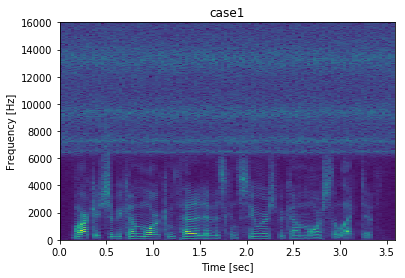

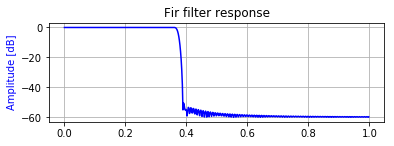

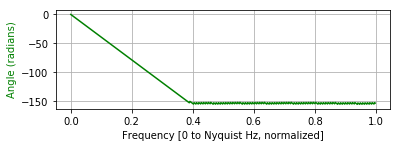

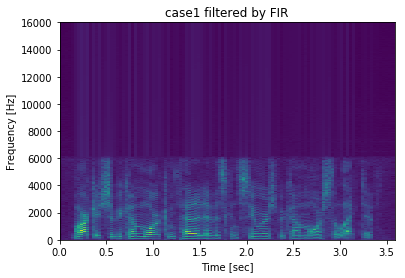

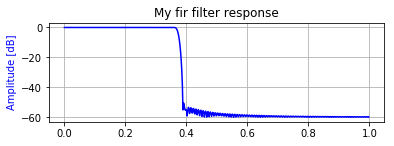

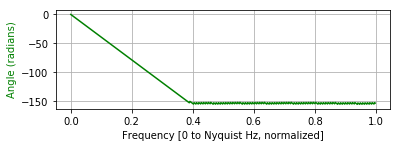

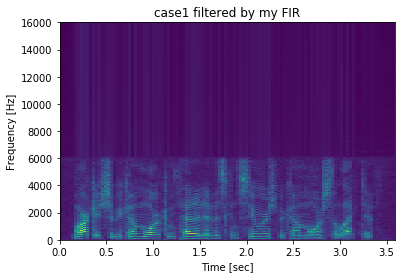

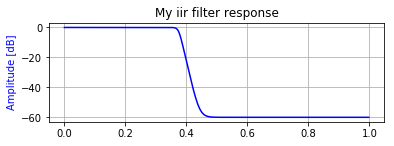

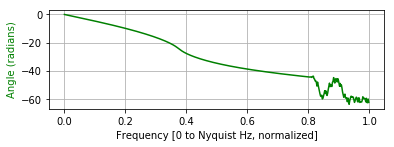

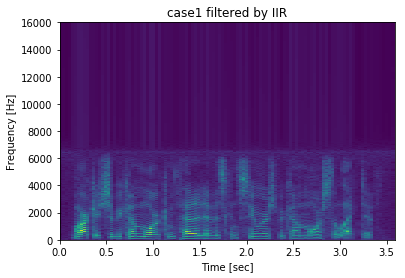

In [3]:
process_pipeline('case1.wav', 251, 31, 'lowpass', np.array([6000, ]))

For case2, we want to filter out the telephone ring while maintain the speaker's voice. The spectrogram shows that the ring spans between about 1800Hz and 3000Hz. Therefore, we should design a bandstop filter with center frequency at $\frac{1800+3000}{2}$=2400Hz and bandwidth of 3000-1800=1200Hz. In the experiments, we find that a 251-tap FIR filter or a 11-tap IIR filter is effective in filtering out the noise, as verified by both the spectrogram of the filtered signal and how it sounds.

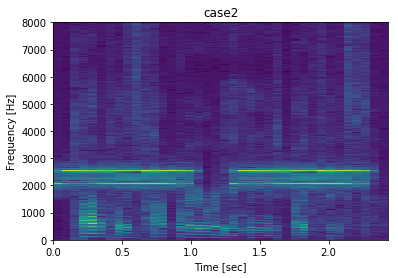

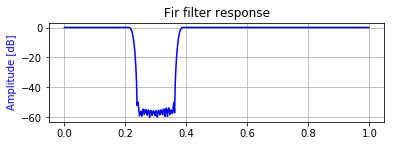

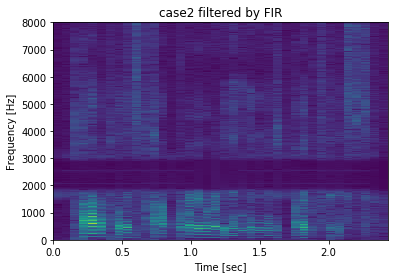

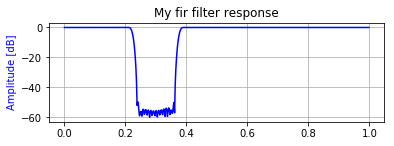

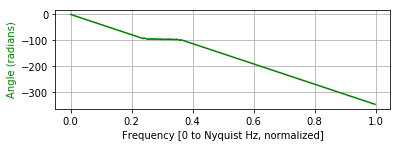

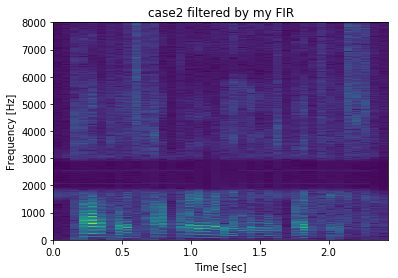

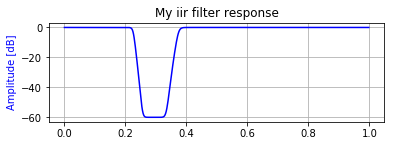

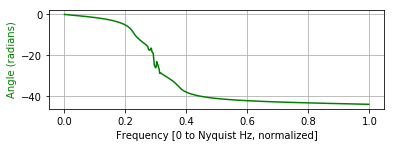

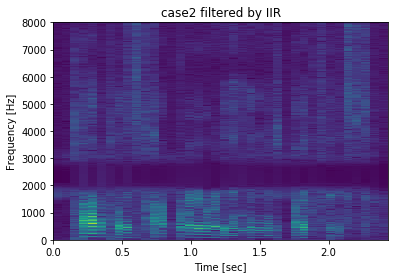

In [4]:
process_pipeline('case2.wav', 251, 11, 'bandstop', np.array([1800, 3000]))

For case3, we want to filter out the thurderstorm while maintain the bird's chirp. The spectrogram shows that the boundary between the thunderstorm and the chirp is about 1500Hz, with the chipr spreading out the high frequency range. Therefore, we should design a highpass filter with cutoff frequency at 1500Hz. In the experiments, we find that a 251-tap FIR filter or a 11-tap IIR filter is effective in filtering out the noise, as verified by both the spectrogram of the filtered signal and how it sounds.

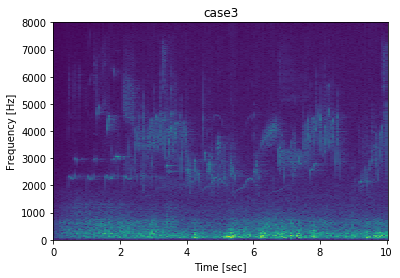

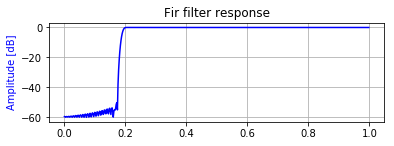

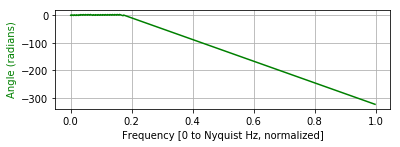

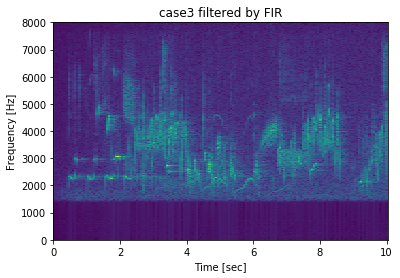

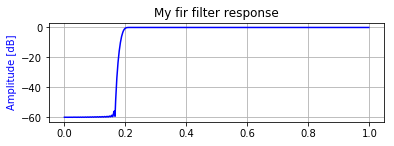

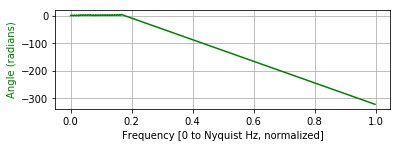

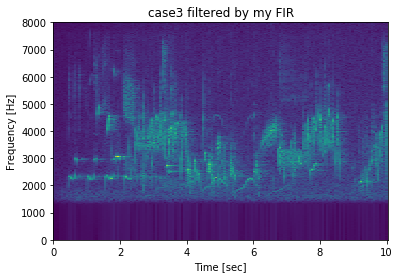

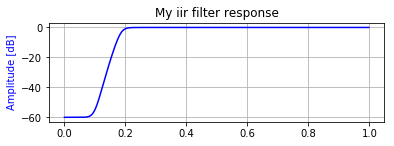

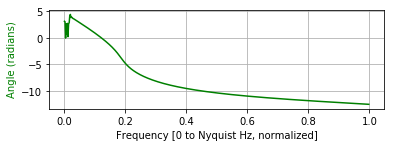

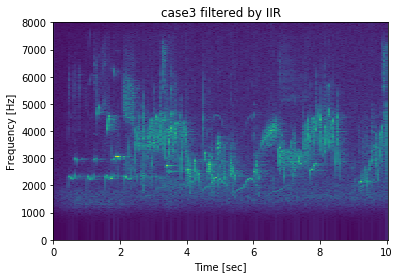

In [5]:
process_pipeline('case3.wav', 251, 11, 'highpass', np.array([1500, ]))

For case4, we want to filter out the noise in underwater environment while maintain the Morse code. The spectrogram shows that the Morse code mainly exists between 700Hz and 1000Hz, where the spectrogram displays very bright band. Therefore, we should design a bandpass filter with center frequency at $\frac{700+1000}{2}$=850Hz and bandwidth of 1000-700=300Hz. In the experiments, we find that a 251-tap FIR filter or a 7-tap IIR filter is effective in filtering out the noise, as verified by both the spectrogram of the filtered signal and how it sounds. It should be noted that 7-tap is the highest IIR order we can use for this case, as higher order results in unstable IIR filter which completely ruins the signal.

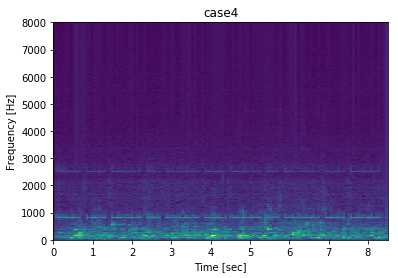

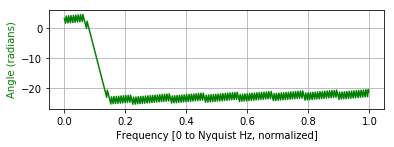

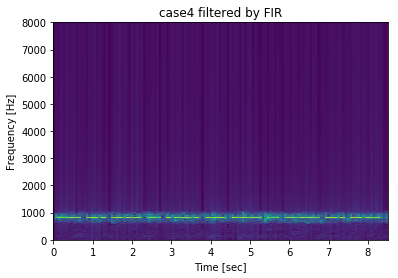

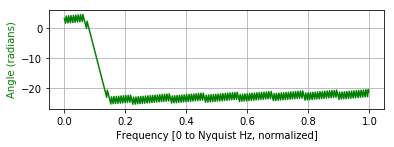

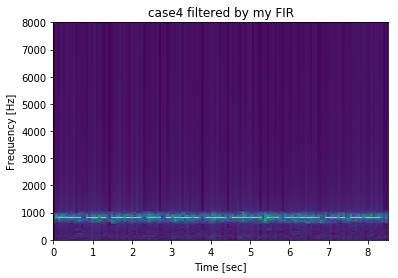

In [6]:
process_pipeline('case4.wav', 251, 7, 'bandpass', np.array([700, 1000]))

## Part 2. Designing a simple equalizer

For this part we will design a simple graphic equalizer. We will do so using a more straightforward approach as opposed to a bank of filters as discussed in class.

We want to make an equalizer which contains six bands with center frequencies at 100Hz, 200Hz, 400Hz, 800Hz, 1600Hz and 3200Hz. Your equalizer function will take two inputs, one for the input sound and a 6-element gain vector that will indicate how much to boost or suppress each frequency band. Use the ```scipy.signal.firwin2``` function to design a filter that has the desired characteristics. For various settings of the gain vector, use the ```scipy.signal.freqz``` command to plot the response of the filter and verify that it behaves as indicated. Experiment with various filter lengths and see which works best.

Once you figure that out, design a graphic equalizer with as many bands as you like (and arbitrary center frequencies as well), and use it to solve the problems in part 1 again. The only thing that should be different in the EQ for each recording should be the gains for each band. Play the output sounds, and show the spectrograms, see how they compare with your previous solutions.

Optional extra credit (+1pt): Use ipywidgets to make intective sliders and process an audio stream and play it from the speakers in real-time (either from mic input, or just stream audio from disk).

In [7]:
def EQ_filter(numtaps, freq, gain):
    filt = signal.firwin2(numtaps=numtaps, freq=freq, gain=gain, antisymmetric=False)
    return filt

def equalizer( input_sound, numtaps, freq, gain):
    filt = EQ_filter(numtaps, freq, gain)
    output_sound = np.convolve(input_sound, filt)
    return output_sound

To verify our equalizer, we design a filter with multiple passbands with center frequencies are 100Hz, 200Hz, 400Hz, 800Hz, 1600Hz and 3200Hz and bandwidth of 100Hz for all passbands. On the frequency response plot, we should expect to see peaks at these frequencies, while all other frequencies should be suppressed. The plot below demonstrates that our equalizer works as expected.

In [8]:
fs = 8000
freq = []
gain = []
for f in [100,200,400,800,1600,3200]:
    freq+=[(f-30)/(fs/2), (f-10)/(fs/2), (f+10)/(fs/2), (f+30)/(fs/2)]
    gain+=[0.0, 1.0, 1.0, 0.0]
freq = [0]+freq+[1]
gain = [0.0]+gain+[0.0]
filt = EQ_filter(2501, freq, gain)
plot_freq_res((filt,1), 'equalizer frequency response')

By making use of the equalizer, we can filter out different types of noise in Part 1 with another approach. Specifically, once we determine the type of filter and the cutoff frequency, we can specify which frequencies we are interested in and what gains we want to assign to each band. The following spectrograms and audio show that the equalizer works just as well as an FIR or IIR.

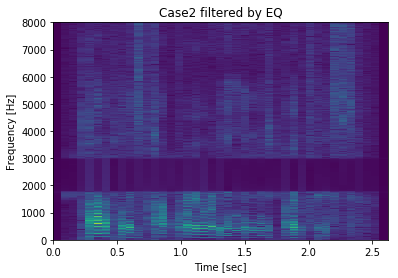

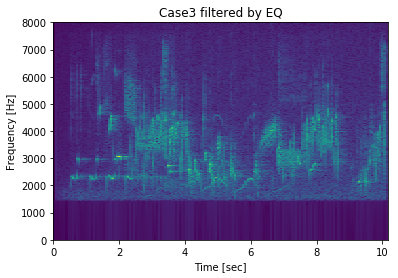

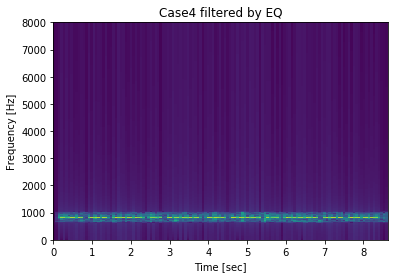

In [9]:
freqs = [[6350, 6450], [1750, 1800, 3000, 3050], [1450, 1550], [650, 700, 1000, 1050]]
gains = [[1.0, 1.0, 0.0, 0.0], [1.0, 1.0, 0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0, 0.0, 0.0]]
for i in range(4):
    fname = 'case'+str(i+1)+'.wav'
    fs, input_sound = load_sound(fname)
    freq = [f/(fs/2) for f in freqs[i]]
    freq = [0]+freq+[1]
    gain = gains[i]
    output_sound = equalizer(input_sound, 2501, freq, gain)
    plot_spectrogram(fs, output_sound, 'Case'+ str(i+1)+ ' filtered by EQ')
    sound(output_sound, rate=fs, label='Case'+ str(i+1)+ ' filtered by EQ')